In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [31]:
# Load datasets
circuits = pd.read_csv('../data/circuits.csv')
constructor_standings = pd.read_csv('../data/constructor_standings.csv')
constructors = pd.read_csv('../data/constructors.csv')
driver_standings = pd.read_csv('../data/driver_standings.csv')
drivers = pd.read_csv('../data/drivers.csv')
lap_times = pd.read_csv('../data/lap_times.csv')
pit_stops = pd.read_csv('../data/pit_stops.csv')
qualifying = pd.read_csv('../data/qualifying.csv')
races = pd.read_csv('../data/races.csv')
results = pd.read_csv('../data/results.csv')
sprint_results = pd.read_csv('../data/sprint_results.csv')
status = pd.read_csv('../data/status.csv')

In [75]:
# Filter only races where driverId 832 or 848 participated
filtered_results = results[results['driverId'].isin([832, 848])]

# Merge with races to get race details
merged = filtered_results.merge(races.rename(columns={'name': 'race_name'}), on='raceId', how='left')

# Merge with drivers
merged = merged.merge(drivers[['driverId', 'forename', 'surname']], on='driverId', how='left')

# Merge with constructors
merged = merged.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
merged.rename(columns={'name': 'constructor_name'}, inplace=True)

# Merge with circuits
merged = merged.merge(circuits[['circuitId', 'name']], on='circuitId', how='left')
merged.rename(columns={'name': 'circuit_name'}, inplace=True)

# Merge with status
merged = merged.merge(status, on='statusId', how='left')


# Now select relevant columns safely
final = merged[[
    'year', 'round', 'raceId', 'race_name', 'circuit_name', 'driverId' , 'forename', 'surname',
    'constructorId', 'constructor_name', 'grid', 'position', 'positionOrder', 'milliseconds', 'points', 'status'
]]

# Combine driver names
final['driver_name'] = final['forename'] + ' ' + final['surname']

# Rearranged final columns
final = final[[
    'year', 'round', 'raceId', 'race_name', 'circuit_name', 'driverId', 'driver_name',
    'constructorId', 'constructor_name', 'grid', 'position', 'positionOrder', 'milliseconds', 'points', 'status'
]]

# Save to CSV
final.to_csv('Williams_driver_race_data.csv', index=False)
print("Final table saved as 'Williams_driver_race_data.csv'")


Final table saved as 'Williams_driver_race_data.csv'


/var/folders/v_/w4dsmhhd5g97lg3hlpkrhnxw0000gn/T/ipykernel_6171/879885756.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['driver_name'] = final['forename'] + ' ' + final['surname']


In [91]:
# Load your dataset
X = pd.read_csv('Williams_driver_race_data.csv')
# Target variable
y = X['positionOrder']
X = X.replace(r'\\N', np.nan, regex=True)
# Feature engineering (drop target + any non-numeric/categorical features that aren't helpful)
X = X.drop(columns=['round', 'race_name', 'circuit_name', 'driver_name', 'constructor_name', 'positionOrder','points', 'status'])
print(X.head())

   year  raceId  driverId  constructorId  grid position milliseconds
0  2015     926       832              5     7        9          NaN
1  2015     927       832              5    15        8          NaN
2  2015     928       832              5    14       13          NaN
3  2015     929       832              5     9      NaN          NaN
4  2015     930       832              5     5        9          NaN


In [92]:
# make all columns numeric
X = X.apply(pd.to_numeric, errors='ignore')

/var/folders/v_/w4dsmhhd5g97lg3hlpkrhnxw0000gn/T/ipykernel_6171/3997024727.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X = X.apply(pd.to_numeric, errors='ignore')


In [93]:
# save X to a csv file
X.to_csv('../notebooks/X.csv', index=False)
y.to_csv('../notebooks/y.csv', index=False)

In [94]:
y.head()

0     9
1     8
2    13
3    19
4     9
Name: positionOrder, dtype: int64

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [97]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  0.4964909553527832
MSE:  1.0530308485031128


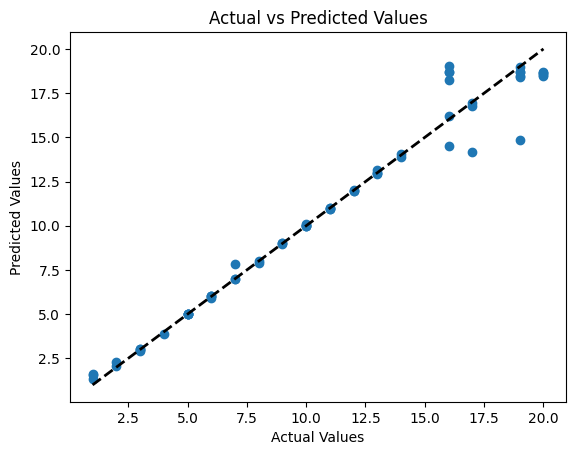

In [98]:
# Make a plot with the predicted values and the actual values
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


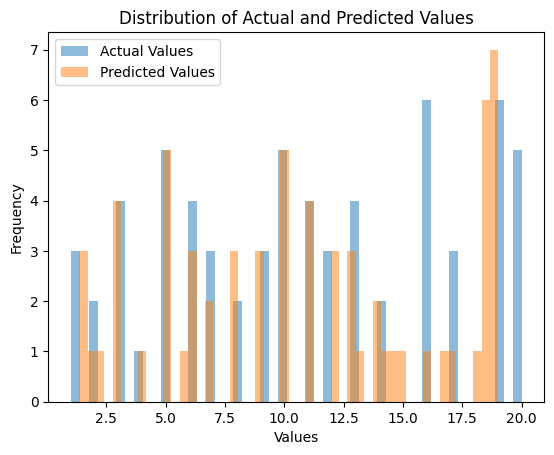

In [99]:
# plot the distribution of actual values and predicted values
plt.hist(y_test, bins=50, alpha=0.5, label='Actual Values')
plt.hist(y_pred, bins=50, alpha=0.5, label='Predicted Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Actual and Predicted Values')
plt.legend()
plt.show()

In [100]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the classifier
classifier_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier_model.fit(X_train, y_train_encoded)
y_pred_encoded = classifier_model.predict(X_test)

# Decode the predictions back to the original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)

Accuracy:  0.7538461538461538
